In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4
import scipy
from scipy import stats
def linr(a,b):
    slope, intercept, r_value, p_value, std_err = stats.linregress(a,b)
    return r_value  # slope or r_value

In [2]:
nino = xr.open_dataset(r'C:\Users\lv299\OneDrive\Melbourne-Uni\Week 4\nino3.4.nc')
nino34 = nino.sst.loc['1982-01-01':'2021-02-01']
nino34 = nino34.resample(time ="M").mean(dim="time")
#chazhi_nino34 = nino34.value
nino34month = nino34.resample(time='QS-DEC').mean(dim="time")
ninoDJF=nino34month[4::4]
ninoDJF['time']=ninoDJF['time.year']
ninoDJF=ninoDJF.rename({'time': 'Year'})

# ninoDJF from 1982_12 1 2 to 2021_12 1 2

ds = ninoDJF
climatology_mean = ds.mean("Year")
climatology_std = ds.std("Year")
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds,
    climatology_mean,
    climatology_std,
)

nino34 = stand_anomalies
print(nino34)


<xarray.DataArray 'sst' (Year: 39)>
array([ 1.9593796 , -0.68229717, -0.98019195, -0.5053686 ,  1.039692  ,
        0.6009188 , -1.6391026 , -0.06724239,  0.2400068 ,  1.5180551 ,
        0.09249036,  0.08570032,  0.8757509 , -0.82440764, -0.42053354,
        2.0966144 , -1.3376818 , -1.4072556 , -0.63720924, -0.15185218,
        0.8496949 ,  0.309525  ,  0.5635616 , -0.64600986,  0.5588848 ,
       -1.4221166 , -0.66910547,  1.2957172 , -1.2992576 , -0.80001634,
       -0.24400538, -0.31294504,  0.55816734,  2.2972798 , -0.29695415,
       -0.8441333 ,  0.77990204,  0.47806737, -1.0117224 ], dtype=float32)
Coordinates:
  * Year     (Year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020


In [3]:
f = xr.open_dataset(r'C:\Users\lv299\OneDrive\Melbourne-Uni\Week 4\Monday\correction.nc')
ds = f.__xarray_dataarray_variable__
print(ds)
nds = ds.loc[:,5:-5.1,:]
print(nds)
varnds = nds.rolling(time = 91, center = True).var().dropna("time")

a = varnds.values
b = np.sqrt(a)
lat = varnds['lat']
lon = varnds['lon']
time = varnds['time']

sqrtvar = xr.DataArray(b,
coords = {'time' : time, 'lat' : lat, 'lon' : lon},
dims = ["time", "lat", "lon"])

a =sqrtvar.mean(axis=1)


<xarray.DataArray '__xarray_dataarray_variable__' (time: 14975, lat: 25, lon: 144)>
[53910000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
  * lat      (lat) float32 30.0 27.5 25.0 22.5 20.0 ... -22.5 -25.0 -27.5 -30.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
<xarray.DataArray '__xarray_dataarray_variable__' (time: 14975, lat: 5, lon: 144)>
[10782000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
  * lat      (lat) float32 5.0 2.5 0.0 -2.5 -5.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5


In [4]:
OLRa = a.resample(time ="M").mean(dim="time")

OLR = OLRa.groupby("time.month")

OLR[12]

<xarray.DataArray (time: 40, lon: 144)>
array([[5.56011509, 5.73203568, 6.20405767, ..., 5.35975048, 5.81977319,
        5.82079427],
       [5.33378701, 6.45318794, 7.74156252, ..., 4.60828219, 4.48703221,
        4.69810323],
       [5.554234  , 6.6908888 , 6.60865385, ..., 4.39821397, 5.0700912 ,
        5.12974053],
       ...,
       [8.99044329, 8.34942275, 8.65499124, ..., 7.50734523, 7.55319312,
        7.94419663],
       [5.61737559, 5.94202591, 6.6960282 , ..., 4.15283099, 4.64240039,
        5.15052001],
       [3.70335348, 4.50223259, 6.29339352, ..., 3.4767156 , 3.90466678,
        4.12385673]])
Coordinates:
  * time     (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2020-12-31
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [5]:
OLR2 = OLR[2]
OLR2['time']=OLR2['time.year']
OLR2=OLR2.rename({'time': 'Year'})
OLR2 = OLR2.loc['1982':'2020']

result2 = np.apply_along_axis(lambda OLR2: linr(OLR2, nino34), axis=0, arr=OLR2)

reg02 =  xr.DataArray(result2, coords= [OLR2.lon]) #converts the output to an xarray DataArray

In [6]:
OLR3 = OLR[3]
OLR3['time']=OLR3['time.year']
OLR3=OLR3.rename({'time': 'Year'})
OLR3 = OLR3.loc['1982':'2020']

result3 = np.apply_along_axis(lambda OLR3: linr(OLR3, nino34), axis=0, arr=OLR3)

reg03=  xr.DataArray(result3, coords= [OLR2.lon],name = 'reg03')

In [7]:
OLR4 = OLR[4]
OLR4['time']=OLR4['time.year']
OLR4=OLR4.rename({'time': 'Year'})
OLR4 = OLR4.loc['1982':'2020']

result4 = np.apply_along_axis(lambda OLR4: linr(OLR4, nino34), axis=0, arr=OLR4)
#result4 = result.reshape(1,144)
reg04 =  xr.DataArray(result4, coords= [OLR2.lon],name = 'reg04')


In [8]:
OLR5 = OLR[5]
OLR5['time']=OLR5['time.year']
OLR5=OLR5.rename({'time': 'Year'})
OLR5 = OLR5.loc['1982':'2020']

result5 = np.apply_along_axis(lambda OLR5: linr(OLR5, nino34), axis=0, arr=OLR5)
#result5 = result.reshape(1,144)
reg05 =  xr.DataArray(result5, coords= [OLR2.lon],name = 'reg05')

In [9]:
OLR6 = OLR[6]
OLR6['time']=OLR6['time.year']
OLR6=OLR6.rename({'time': 'Year'})
OLR6 = OLR6.loc['1982':'2020']

result6 = np.apply_along_axis(lambda OLR6: linr(OLR6, nino34), axis=0, arr=OLR6)
#result6 = result.reshape(1,144)
reg06 =  xr.DataArray(result6, coords= [OLR2.lon],name = 'reg06')

In [10]:
OLR7 = OLR[7]
OLR7['time']=OLR7['time.year']
OLR7=OLR7.rename({'time': 'Year'})
OLR7 = OLR7.loc['1982':'2020']

result7 = np.apply_along_axis(lambda OLR7: linr(OLR7, nino34), axis=0, arr=OLR7)
#result7 = result.reshape(1,144)
reg07 =  xr.DataArray(result7,coords= [OLR2.lon],name = 'reg07')

In [11]:
OLR8 = OLR[8]
OLR8['time']=OLR8['time.year']
OLR8=OLR8.rename({'time': 'Year'})
OLR8 = OLR8.loc['1982':'2020']

result8 = np.apply_along_axis(lambda OLR8: linr(OLR8, nino34), axis=0, arr=OLR8)
#result8 = result.reshape(1,144)
reg08 =  xr.DataArray(result8, coords= [OLR2.lon],name = 'reg08')

In [12]:
OLR9 = OLR[9]
OLR9['time']=OLR9['time.year']
OLR9=OLR9.rename({'time': 'Year'})
OLR9 = OLR9.loc['1982':'2020']

result9 = np.apply_along_axis(lambda OLR9: linr(OLR9, nino34), axis=0, arr=OLR9)
#result9 = result.reshape(1,144)
reg09 =  xr.DataArray(result9, coords= [OLR2.lon],name = 'reg09')

In [13]:
OLR10 = OLR[10]
OLR10['time']=OLR10['time.year']
OLR10=OLR10.rename({'time': 'Year'})
OLR10 = OLR10.loc['1982':'2020']

result10 = np.apply_along_axis(lambda OLR10: linr(OLR10, nino34), axis=0, arr=OLR10)
#result10 = result.reshape(1,144)
reg10 =  xr.DataArray(result10,coords= [OLR2.lon],name = 'reg10')

In [14]:
OLR11 = OLR[11]
OLR11['time']=OLR11['time.year']
OLR11=OLR11.rename({'time': 'Year'})
OLR11 = OLR11.loc['1982':'2020']

result11 = np.apply_along_axis(lambda OLR11: linr(OLR11, nino34), axis=0, arr=OLR11)
#result11 = result.reshape(1,144)
reg11 =  xr.DataArray(result11, coords= [OLR2.lon],name = 'reg11')

In [15]:
OLR12 = OLR[12]
OLR12['time']=OLR12['time.year']
OLR12=OLR12.rename({'time': 'Year'})
OLR12 = OLR12.loc['1982':'2020']
print(OLR12)
result12 = np.apply_along_axis(lambda OLR12: linr(OLR12, nino34), axis=0, arr=OLR12)
#result12 = result.reshape(1,144)
reg12 =  xr.DataArray(result12, coords= [OLR2.lon],name = 'reg12')

<xarray.DataArray (Year: 39, lon: 144)>
array([[5.33378701, 6.45318794, 7.74156252, ..., 4.60828219, 4.48703221,
        4.69810323],
       [5.554234  , 6.6908888 , 6.60865385, ..., 4.39821397, 5.0700912 ,
        5.12974053],
       [7.29791975, 7.65456048, 9.2024293 , ..., 6.86051832, 6.77955832,
        7.59258361],
       ...,
       [8.99044329, 8.34942275, 8.65499124, ..., 7.50734523, 7.55319312,
        7.94419663],
       [5.61737559, 5.94202591, 6.6960282 , ..., 4.15283099, 4.64240039,
        5.15052001],
       [3.70335348, 4.50223259, 6.29339352, ..., 3.4767156 , 3.90466678,
        4.12385673]])
Coordinates:
  * Year     (Year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5


In [16]:
test = xr.DataArray([result2,result3,result4,result5,result6,result7,result8,result9,result10,result11,result12],
        dims=("time", "lon"), coords={"time": [2,3,4,5,6,7,8,9,10,11,12], "lon": OLR2.lon},name = 'reg')

test.max()

<xarray.DataArray 'reg' ()>
array(0.79819972)

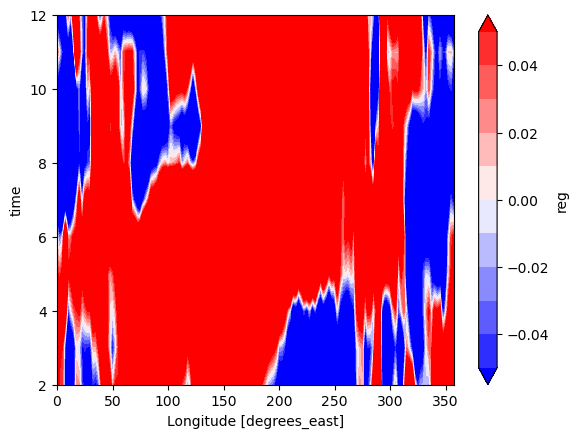

In [17]:

test.plot.contourf(cmap = 'bwr', levels = np.arange(-0.05,0.0501,0.01))


In [18]:
OLR13 = OLR[1]
OLR13['time']=OLR13['time.year']
OLR13=OLR13.rename({'time': 'Year'})
OLR13 = OLR13.loc['1983':'2021']

result13 = np.apply_along_axis(lambda OLR13: linr(OLR13, nino34), axis=0, arr=OLR13)

reg13 =  xr.DataArray(result13, coords= [OLR13.lon])

In [19]:
OLR14 = OLR[2]
OLR14['time']=OLR14['time.year']
OLR14=OLR14.rename({'time': 'Year'})
OLR14 = OLR14.loc['1983':'2021']

result14 = np.apply_along_axis(lambda OLR14: linr(OLR14, nino34), axis=0, arr=OLR14)

reg14 =  xr.DataArray(result14, coords= [OLR14.lon])

In [20]:
OLR15 = OLR[3]
OLR15['time']=OLR15['time.year']
OLR15=OLR15.rename({'time': 'Year'})
OLR15 = OLR15.loc['1983':'2021']

result15 = np.apply_along_axis(lambda OLR15: linr(OLR15, nino34), axis=0, arr=OLR15)

reg15 =  xr.DataArray(result15, coords= [OLR15.lon])

In [21]:
OLR16 = OLR[4]
OLR16['time']=OLR16['time.year']
OLR16=OLR16.rename({'time': 'Year'})
OLR16 = OLR16.loc['1983':'2021']

result16 = np.apply_along_axis(lambda OLR16: linr(OLR16, nino34), axis=0, arr=OLR16)

reg16 =  xr.DataArray(result16, coords= [OLR16.lon])

In [22]:
OLR17 = OLR[5]
OLR17['time']=OLR17['time.year']
OLR17=OLR17.rename({'time': 'Year'})
OLR17 = OLR17.loc['1983':'2021']

result17 = np.apply_along_axis(lambda OLR17: linr(OLR17, nino34), axis=0, arr=OLR17)

reg17 =  xr.DataArray(result17, coords= [OLR17.lon])

In [23]:
OLR18 = OLR[6]
OLR18['time']=OLR18['time.year']
OLR18=OLR18.rename({'time': 'Year'})
OLR18 = OLR18.loc['1983':'2021']

result18 = np.apply_along_axis(lambda OLR18: linr(OLR18, nino34), axis=0, arr=OLR18)

reg18 =  xr.DataArray(result18, coords= [OLR18.lon])

In [24]:
OLR19 = OLR[7]
OLR19['time']=OLR19['time.year']
OLR19=OLR19.rename({'time': 'Year'})
OLR19 = OLR19.loc['1983':'2021']

result19 = np.apply_along_axis(lambda OLR19: linr(OLR19, nino34), axis=0, arr=OLR19)

reg19 =  xr.DataArray(result19, coords= [OLR19.lon])

In [25]:
OLR20 = OLR[8]
OLR20['time']=OLR20['time.year']
OLR20=OLR20.rename({'time': 'Year'})
OLR20 = OLR20.loc['1983':'2021']

result20 = np.apply_along_axis(lambda OLR20: linr(OLR20, nino34), axis=0, arr=OLR20)

reg20 =  xr.DataArray(result20, coords= [OLR20.lon])

In [26]:
test = xr.DataArray([result2,result3,result4,result5,result6,result7,result8,result9,result10,result11,result12,result13,result14,result15,result16,result17,result18,result19,result20],
        dims=("time", "lon"), coords={"time": ['Feb(0)','Mar(0)','Apr(0)','May(0)','Jun(0)','Jul(0)','Aug(0)','Sept(0)','Oct(0)','Nov(0)','Dec(0)','Jan(1)','Feb(1)','Mar(1)','Apr(1)','May(1)','Jun(1)','Jul(1)','Aug(1)'], "lon": OLR2.lon},name = 'reg')

print(test.min())
print(test.max())

<xarray.DataArray 'reg' ()>
array(-0.4898253)
<xarray.DataArray 'reg' ()>
array(0.79819972)


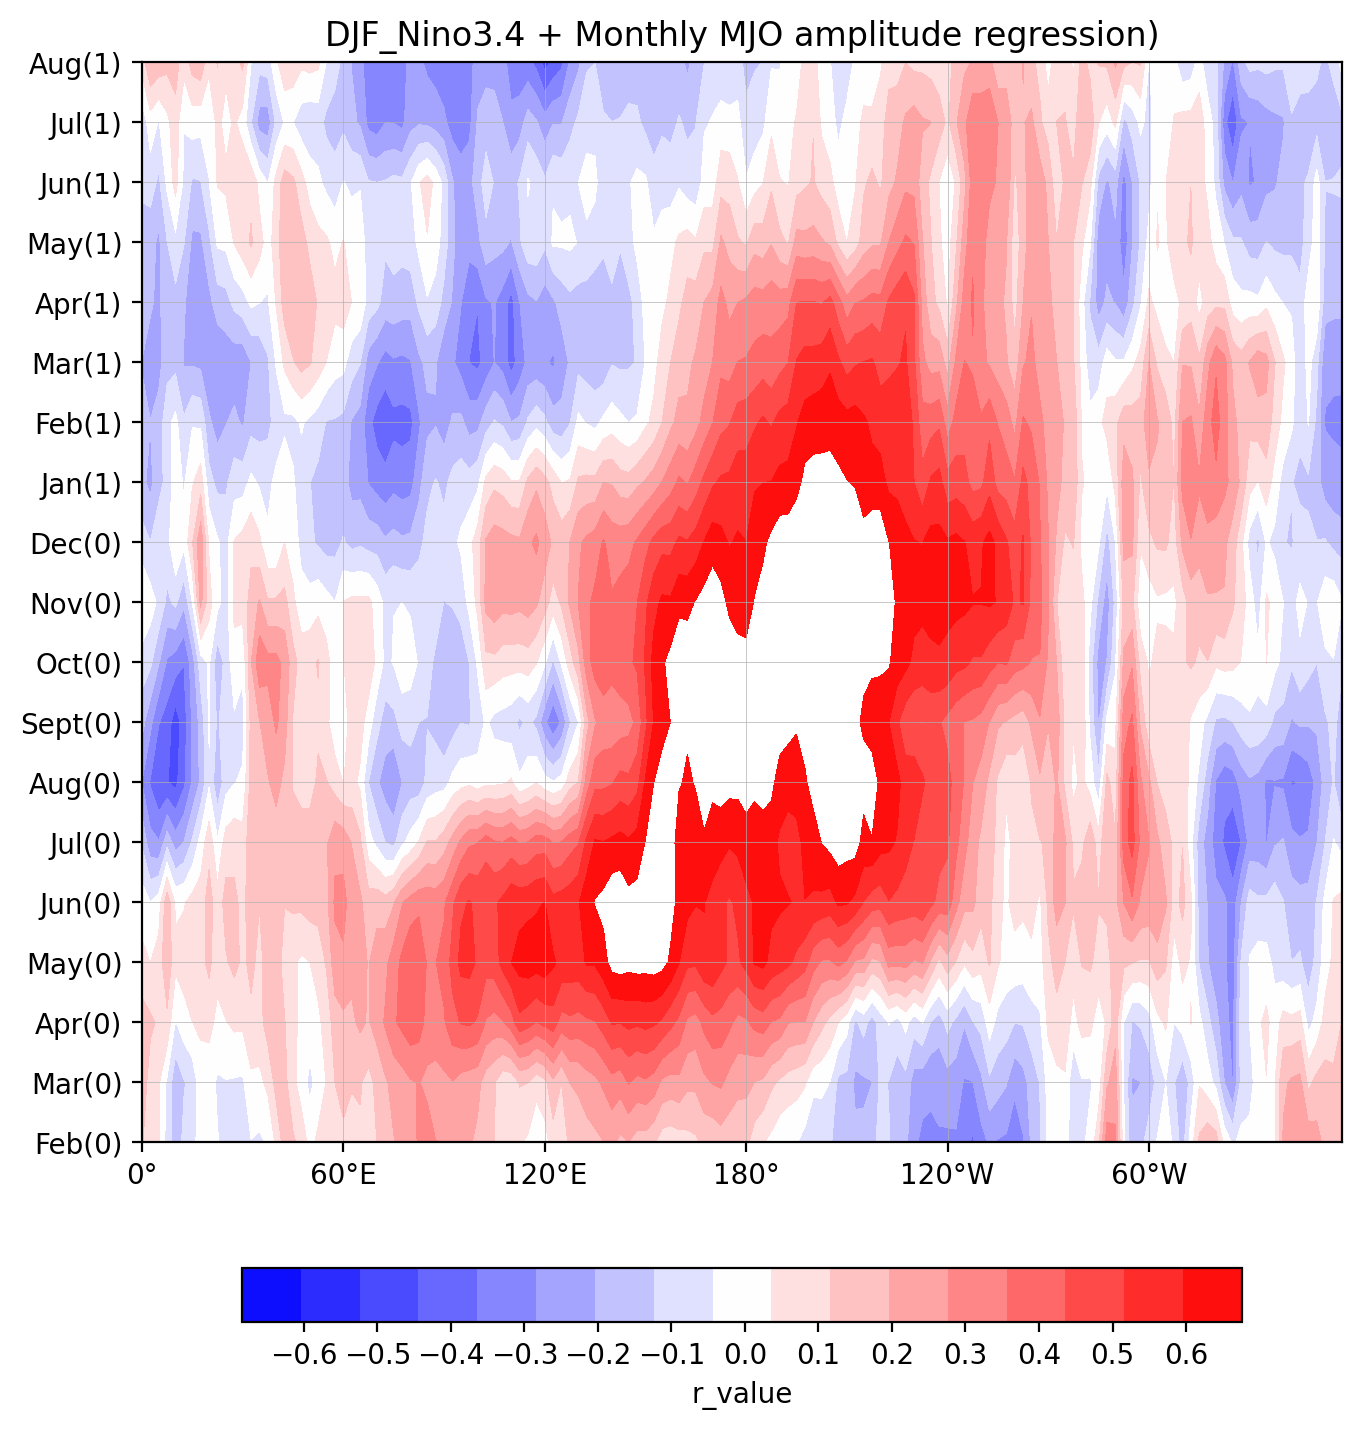

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (0,420,-20,20)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()




fig = plt.figure(figsize=[10,9],dpi=200,facecolor='white')
ax = fig.add_axes([0.1, 0.2, 0.6, 0.6])
ax.set_xticks(range(0,360,60), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.title.set_text('DJF_Nino3.4 + Monthly MJO amplitude regression)')
c = ax.contourf(test.lon, test.time, test,
                cmap = plt.get_cmap('bwr'),
                levels = np.arange(-0.684,0.690,0.08))
plt.grid(linewidth=0.25)

fig.colorbar(c, cax=fig.add_axes([0.15, 0.1, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'r_value', 
             ticks=np.arange(-0.7,0.71,0.1),
             shrink=0.7)


In [28]:
print(np.linspace(-0.8,0.8,17))

[-0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8]


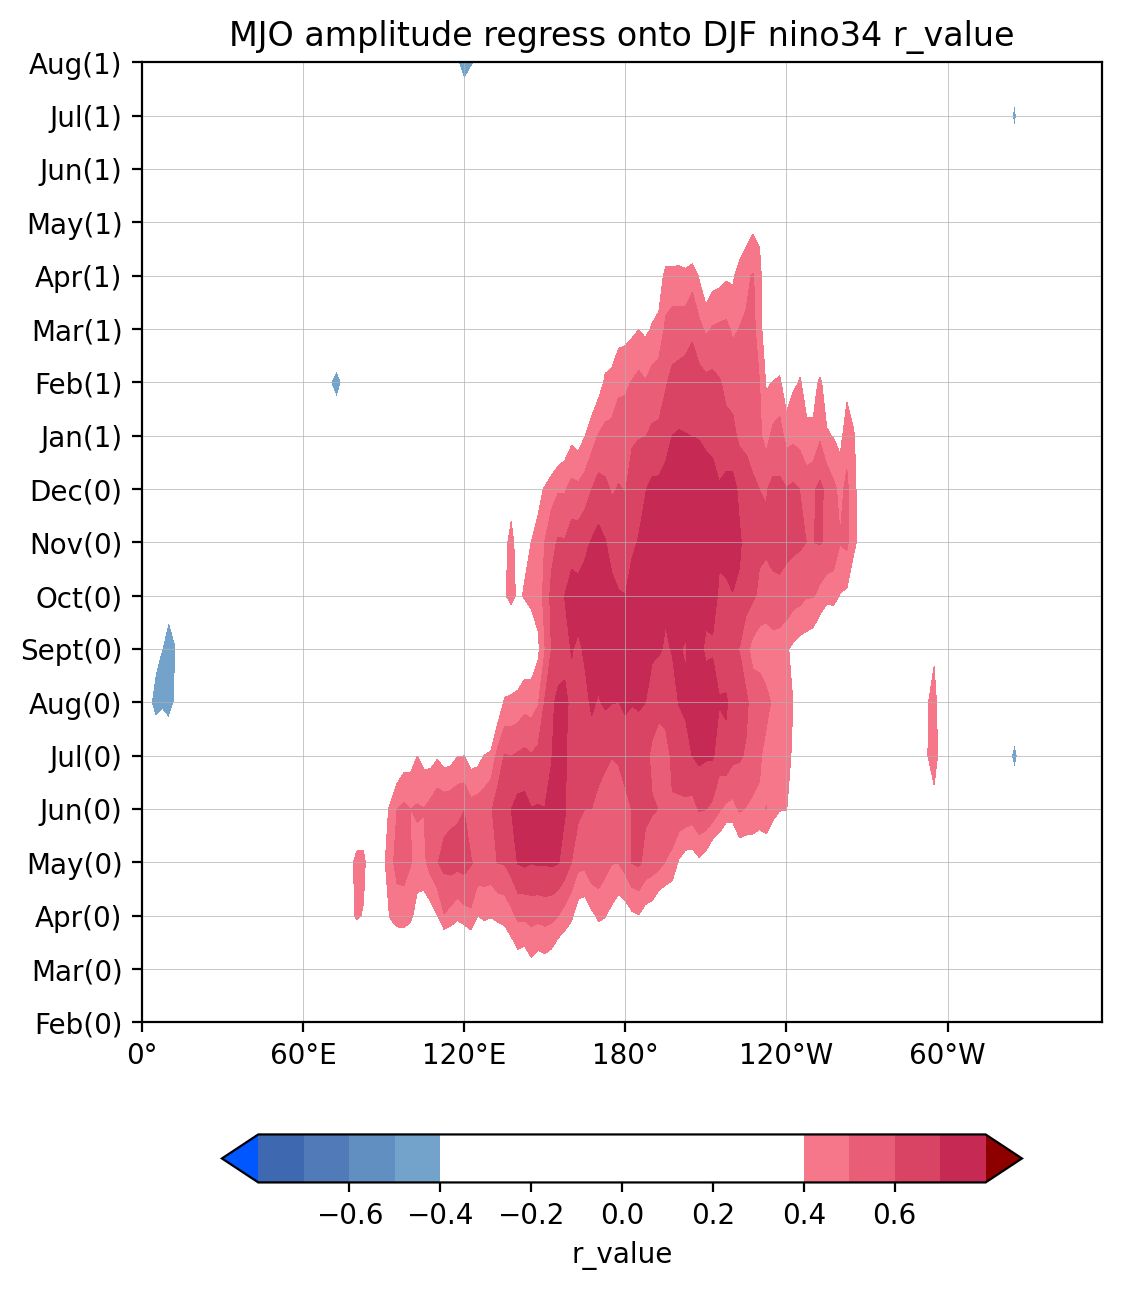

In [29]:
import matplotlib.colors as colors
import matplotlib as mpl
colors = [ '#3e68af', '#507bb8', '#618fc1', '#73a3ca', '#ffffff', '#ffffff', 
          '#ffffff', '#ffffff','#ffffff','#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#f57789', 
          '#e95d76', '#d94364', '#c62a54']#this is a blue white red colorbar
cmap = mpl.colors.ListedColormap(colors)
cmap.set_under("#0056FF") #this is to have arrows at the beginning and end i.e. extend='both'
cmap.set_over("#8E0000")
norm = mpl.colors.Normalize(vmin=-0.8,vmax=0.8)
levels = np.linspace(-0.8,0.8,17)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 

lon_formatter = cticker.LongitudeFormatter()

fig = plt.figure(figsize=[8,8],dpi=200,facecolor='white')
ax = fig.add_axes([0.1, 0.2, 0.6, 0.6])
ax.set_xticks(range(0,360,60))
ax.xaxis.set_major_formatter(lon_formatter)
ax.title.set_text('MJO amplitude regress onto DJF nino34 r_value')

c = ax.contourf(test.lon, test.time, test,
                levels=levels,
                norm=norm, 
                extend='both' ,
                cmap=cmap
               )
plt.grid(linewidth=0.25)

fig.colorbar(c, cax=fig.add_axes([0.15, 0.1, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'r_value', 
             ticks=np.arange(-0.6,0.61,0.2),
             shrink=0.7)

